<a href="https://colab.research.google.com/github/blparish/Confluence-Test--Training-Evaluation/blob/main/Run_Cellpose_SAM_Multi_image_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Cellpose-SAM: superhuman generalization for cellular segmentation

Marius Pachitariu, Michael Rariden, Carsen Stringer

[paper](https://www.biorxiv.org/content/10.1101/2025.04.28.651001v1) | [code](https://github.com/MouseLand/cellpose)

This notebook shows how to process your own 2D or 3D images, saved on Google Drive.

This notebook is adapted from the notebook by Pradeep Rajasekhar, inspired by the [ZeroCostDL4Mic notebook series](https://github.com/HenriquesLab/ZeroCostDL4Mic/wiki).

### Mount your google drive

Run this cell to connect your Google Drive to colab:
* Click on the URL.
* Sign in your Google Account.

You will either have to:
* copy the authorisation code and enter it into box below OR
* in the new google colab, you can just click "Allow" and it should connect.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



Then click on "Folder" icon on the Left, press the refresh button. Your Google Drive folder should now be available here as "gdrive".


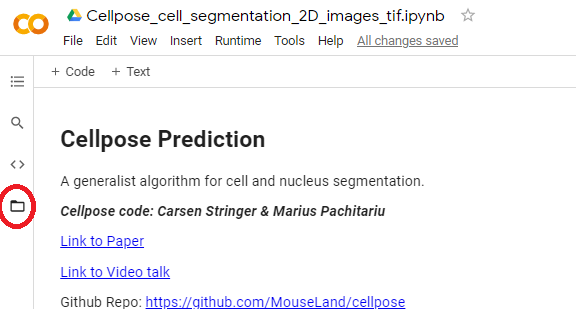

Check GPU and instantiate model - will download weights.

In [ ]:
import numpy as np
from cellpose import models, core, io, plot
from pathlib import Path
from tqdm import trange
import matplotlib.pyplot as plt
from natsort import natsorted

io.logger_setup() # run this to get printing of progress

#Check if colab notebook instance has GPU access
if core.use_gpu()==False:
  raise ImportError("No GPU access, change your runtime")

model = models.CellposeModel(gpu=True)



Welcome to CellposeSAM, cellpose v
cellpose version: 	4.0.6 
platform:       	linux 
python version: 	3.11.13 
torch version:  	2.6.0+cu124! The neural network component of
CPSAM is much larger than in previous versions and CPU excution is slow. 
We encourage users to use GPU/MPS if available. 


creating new log file
2025-07-13 00:46:22,432 [INFO] WRITING LOG OUTPUT TO /root/.cellpose/run.log
2025-07-13 00:46:22,432 [INFO] 
cellpose version: 	4.0.6 
platform:       	linux 
python version: 	3.11.13 
torch version:  	2.6.0+cu124
2025-07-13 00:46:22,635 [INFO] ** TORCH CUDA version installed and working. **
2025-07-13 00:46:22,636 [INFO] ** TORCH CUDA version installed and working. **
2025-07-13 00:46:22,637 [INFO] >>>> using GPU (CUDA)
2025-07-13 00:46:25,443 [INFO] Downloading: "https://huggingface.co/mouseland/cellpose-sam/resolve/main/cpsam" to /root/.cellpose/models/cpsam



100%|██████████| 1.15G/1.15G [00:02<00:00, 417MB/s]


Input directory with your images:

In [ ]:
# change to your google drive folder path
dir = "/content/drive/MyDrive/GWU/Praxis/Images/test/"
dir = Path(dir)
if not dir.exists():
  raise FileNotFoundError("directory does not exist")

# change to your image extension
image_ext = "_img.png"

# list all files
files = natsorted([f for f in dir.glob("*"+image_ext) if "_masks" not in f.name and "_flows" not in f.name])

if(len(files)==0):
  raise FileNotFoundError("no image files found, did you specify the correct folder and extension?")
else:
  print(f"{len(files)} images in folder:")

for f in files:
  print(f.name)

68 images in folder:
000_img.png
001_img.png
002_img.png
003_img.png
004_img.png
005_img.png
006_img.png
007_img.png
008_img.png
009_img.png
010_img.png
011_img.png
012_img.png
013_img.png
014_img.png
015_img.png
016_img.png
017_img.png
018_img.png
019_img.png
020_img.png
021_img.png
022_img.png
023_img.png
024_img.png
025_img.png
026_img.png
027_img.png
028_img.png
029_img.png
030_img.png
031_img.png
032_img.png
033_img.png
034_img.png
035_img.png
036_img.png
037_img.png
038_img.png
039_img.png
040_img.png
041_img.png
042_img.png
043_img.png
044_img.png
045_img.png
046_img.png
047_img.png
048_img.png
049_img.png
050_img.png
051_img.png
052_img.png
053_img.png
054_img.png
055_img.png
056_img.png
057_img.png
058_img.png
059_img.png
060_img.png
061_img.png
062_img.png
063_img.png
064_img.png
065_img.png
066_img.png
067_img.png


## Run Cellpose-SAM on one image in folder

Here are some of the parameters you can change:

* ***flow_threshold*** is  the  maximum  allowed  error  of  the  flows  for  each  mask.   The  default  is 0.4.
    *  **Increase** this threshold if cellpose is not returning as many masks as you’d expect (or turn off completely with 0.0)
    *   **Decrease** this threshold if cellpose is returning too many ill-shaped masks.

* ***cellprob_threshold*** determines proability that a detected object is a cell.   The  default  is 0.0.
    *   **Decrease** this threshold if cellpose is not returning as many masks as you’d expect or if masks are too small
    *   **Increase** this threshold if cellpose is returning too many masks esp from dull/dim areas.

* ***tile_norm_blocksize*** determines the size of blocks used for normalizing the image. The default is 0, which means the entire image is normalized together.
  You may want to change this to 100-200 pixels if you have very inhomogeneous brightness across your image.



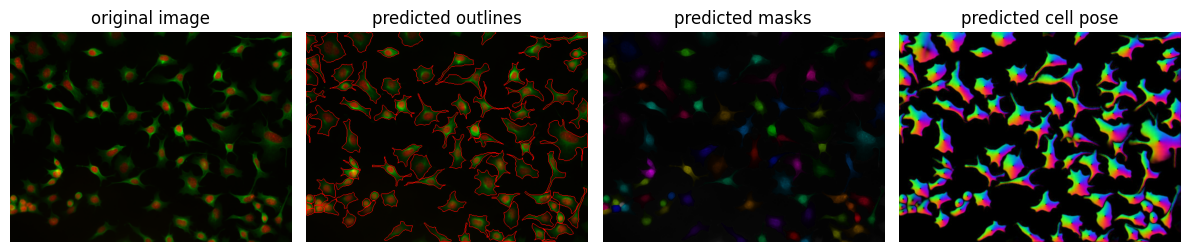

In [ ]:
from skimage import io
from cellpose import plot
import matplotlib.pyplot as plt
import numpy as np

# Read your image
img = io.imread(files[0])  # make sure 'files' list is already defined

# Handle dimensional issues
# If image has shape (3, H, W), assume (C, H, W) and convert to (H, W, C)
if img.ndim == 3 and img.shape[0] == 3 and img.shape[2] != 3:
    img = np.transpose(img, (1, 2, 0))

# Fix value scaling for display
if img.dtype in (np.float32, np.float64):
    img_disp = np.clip(img / img.max(), 0, 1)
elif img.dtype == np.uint16:
    img_disp = (img / 256).astype(np.uint8)
else:
    img_disp = img

# Run model
flow_threshold = 0.4
cellprob_threshold = 0.0
tile_norm_blocksize = 0

masks, flows, styles = model.eval(
    img,
    batch_size=32,
    flow_threshold=flow_threshold,
    cellprob_threshold=cellprob_threshold,
    normalize={"tile_norm_blocksize": tile_norm_blocksize},
)

fig = plt.figure(figsize=(12, 5))
_ = plot.show_segmentation(fig, img_disp, masks, flows[0])
plt.tight_layout()
plt.show()


## Run Cellpose-SAM on folder of images

if you have many large images, you may want to run them as a loop over images



In [ ]:
masks_ext = "_masks.png" if image_ext == "_img.png" else ".tif"


# create the new sub-folder (only if it doesn’t exist)
out_dir = dir / "SAM2test"          # dir is your existing Path object
out_dir.mkdir(exist_ok=True)

for i in trange(len(files)):
    f = files[i]
    img = io.imread(f)
    masks, flows, styles = model.eval(img, batch_size=32, flow_threshold=flow_threshold, cellprob_threshold=cellprob_threshold,
                                  normalize={"tile_norm_blocksize": tile_norm_blocksize})
    io.imsave(out_dir / (f.stem + "_SAM2masks" + masks_ext), masks)
    print(" Masks saved in", out_dir)

100%|██████████| 68/68 [03:01<00:00,  2.67s/it]


\if you have small images, you may want to load all of them first and then run, so that they can be batched together on the GPU

In [ ]:
print("loading images")
imgs = [io.imread(files[i]) for i in trange(len(files))]

print("running cellpose-SAM")
masks, flows, styles = model.eval(imgs, batch_size=32, flow_threshold=flow_threshold, cellprob_threshold=cellprob_threshold,
                                  normalize={"tile_norm_blocksize": tile_norm_blocksize})

print("saving masks")
for i in trange(len(files)):
    f = files[i]
    io.imsave(dir / (f.stem + "_masks" + masks_ext), masks[i])

In [ ]:
print("Images loaded into df_all:", len(df_all))
print("First few rows:")
print(df_all.head())


In [ ]:
from pathlib import Path
import numpy as np, pandas as pd
from skimage.io import imread
from tqdm import trange
import random

# Paths
ROOT = Path("/content/drive/MyDrive/Images")
TEST_DIR = ROOT / "test"
SAM_DIR = TEST_DIR / "SAM2test"
OUT_DIR = ROOT / "sampling_analysis"
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Microscope FOV → cm²
FN_MM, MAG = 22, 4
A_FOV_CM2 = (np.pi * (FN_MM / MAG / 2)**2) / 100.0

# Collect metrics from all images
records = []
image_paths = list(TEST_DIR.glob("*_img.png"))

for img_path in image_paths:
    img_id = img_path.name.split("_img")[0]
    gt_path = TEST_DIR / f"{img_id}_masks.png"
    pr_path = SAM_DIR / f"{img_id}_img_SAM2masks.png"

    if not gt_path.exists() or not pr_path.exists():
        print(f"Missing pair for {img_id}")
        continue

    gt_raw = imread(gt_path)
    pr_raw = imread(pr_path)

    gt_bin = gt_raw > 0
    pr_bin = pr_raw > 0

    conf_gt = gt_bin.mean()
    conf_pr = pr_bin.mean()
    tnc_gt = int(gt_raw.max())
    tnc_pr = int(pr_raw.max())
    vcd_gt = tnc_gt / A_FOV_CM2
    vcd_pr = tnc_pr / A_FOV_CM2

    records.append({
        "image": img_id,
        "conf_gt": conf_gt,
        "conf_pr": conf_pr,
        "tnc_gt": tnc_gt,
        "tnc_pr": tnc_pr,
        "vcd_gt": vcd_gt,
        "vcd_pr": vcd_pr,
    })

df_all = pd.DataFrame(records)
df_all.to_csv(OUT_DIR / "all_image_kpis.csv", index=False)
print(f"Images loaded into df_all: {len(df_all)}")
print(df_all.head())

# Sampling simulation
sample_results = []
repeats = 50
max_k = min(10, len(df_all))

for k in range(1, max_k + 1):
    for _ in range(repeats):
        sample = df_all.sample(n=k, replace=False)

        for metric in ["conf", "vcd"]:
            pred_vals = sample[f"{metric}_pr"]
            gt_vals = sample[f"{metric}_gt"]

            pred_avg = pred_vals.mean()
            gt_avg = gt_vals.mean()
            abs_err = abs(pred_avg - gt_avg)
            sq_err = (pred_avg - gt_avg) ** 2
            cv = pred_vals.std() / pred_vals.mean() if pred_vals.mean() != 0 else np.nan

            sample_results.append({
                "k": k,
                "metric": metric.upper(),
                "MAE": abs_err,
                "RMSE": np.sqrt(sq_err),
                "CV": cv,
            })

df_raw = pd.DataFrame(sample_results)

# Validate expected columns before groupby
expected_cols = {"k", "metric", "MAE", "RMSE", "CV"}
if not expected_cols.issubset(df_raw.columns):
    print("Column check failed. Columns present:", df_raw.columns.tolist())
    raise ValueError("One or more expected columns are missing.")

# Summary
df_summary = df_raw.groupby(["k", "metric"]).agg(
    MAE=("MAE", "mean"),
    RMSE=("RMSE", "mean"),
    Mean_CV=("CV", "mean")
).reset_index()

# Save outputs
df_raw.to_csv(OUT_DIR / "sampling_simulations_raw.csv", index=False)
df_summary.to_csv(OUT_DIR / "sampling_simulations_summary.csv", index=False)

print("Simulation completed. Results saved to:", OUT_DIR)


Images loaded into df_all: 68
  image   conf_gt   conf_pr  tnc_gt  tnc_pr      vcd_gt      vcd_pr
0   008  0.208734  0.179315      41      41  172.571310  172.571310
1   003  0.324209  0.315815      47      46  197.825648  193.616592
2   005  0.039460  0.036212       8       8   33.672451   33.672451
3   006  0.183451  0.190432      50      50  210.452817  210.452817
4   007  0.193415  0.191386      42      42  176.780367  176.780367
Simulation completed. Results saved to: /content/drive/MyDrive/GWU/Praxis/Images/sampling_analysis


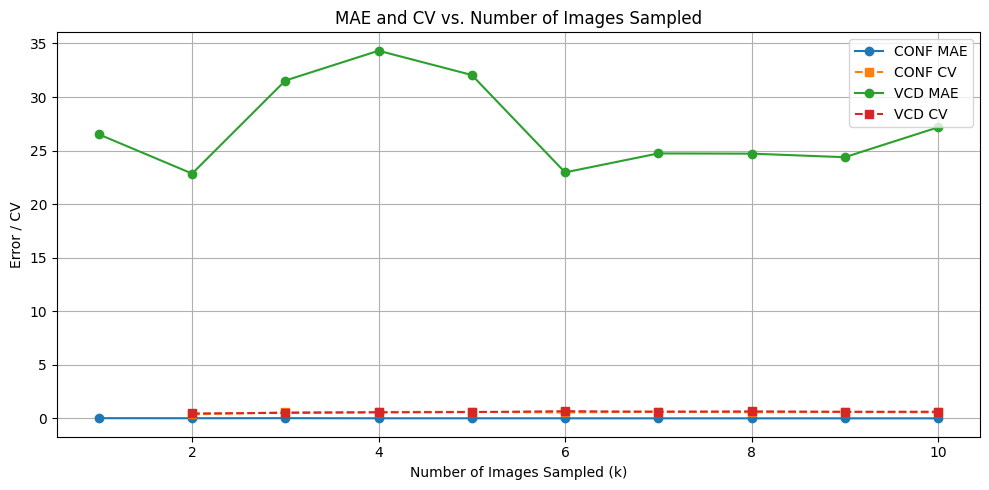

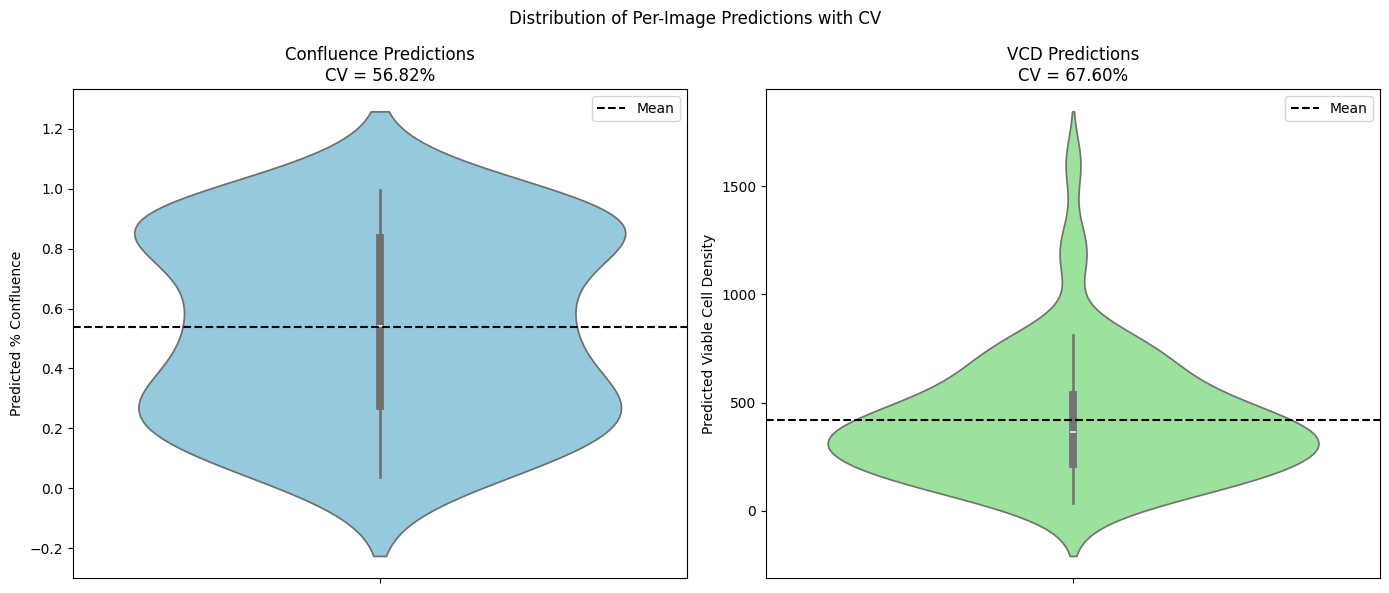

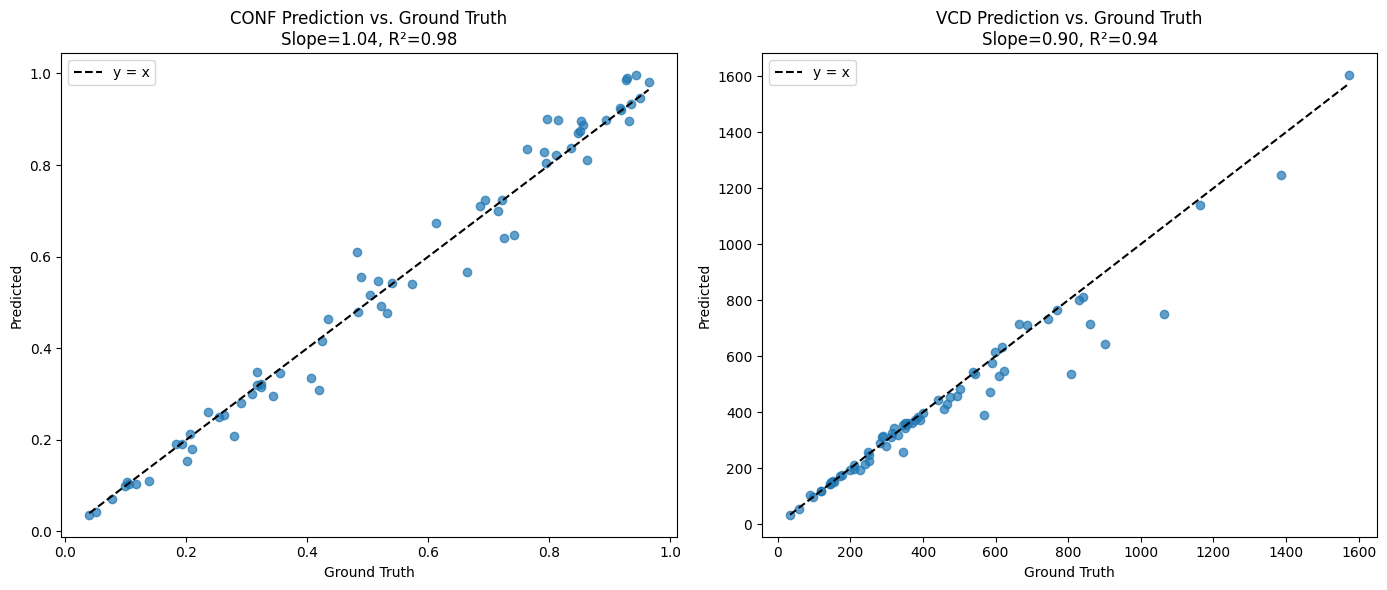

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.metrics import r2_score
import numpy as np

# Paths
root = Path("/content/drive/MyDrive/Images/sampling_analysis")
fig_dir = Path("/content/drive/MyDrive/Figures")
fig_dir.mkdir(parents=True, exist_ok=True)

df_all = pd.read_csv(root / "all_image_kpis.csv")
df_raw = pd.read_csv(root / "sampling_simulations_raw.csv")

# MAE & CV vs. Number of Images Sampled (k)
plt.figure(figsize=(10, 5))

for metric in ['CONF', 'VCD']:
    subset = df_raw[df_raw['metric'] == metric]
    mae_means = subset.groupby('k')["MAE"].mean()
    cv_means = subset.groupby('k')["CV"].mean()

    plt.plot(mae_means.index, mae_means, marker='o', label=f'{metric} MAE')
    plt.plot(cv_means.index, cv_means, marker='s', linestyle='--', label=f'{metric} CV')

plt.xlabel("Number of Images Sampled (k)")
plt.ylabel("Error / CV")
plt.title("MAE and CV vs. Number of Images Sampled")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(fig_dir / "mae_cv_vs_k.png", dpi=300)
plt.show()

# Violin/Boxplots of Per-Image Predicted Values with CV
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Confluence
sns.violinplot(data=df_all, y="conf_pr", ax=axs[0], color='skyblue')
axs[0].axhline(df_all["conf_pr"].mean(), ls='--', color='black', label='Mean')
cv_conf = 100 * df_all["conf_pr"].std() / df_all["conf_pr"].mean()
axs[0].set_title(f"Confluence Predictions\nCV = {cv_conf:.2f}%")
axs[0].set_ylabel("Predicted % Confluence")
axs[0].legend()

# VCD
sns.violinplot(data=df_all, y="vcd_pr", ax=axs[1], color='lightgreen')
axs[1].axhline(df_all["vcd_pr"].mean(), ls='--', color='black', label='Mean')
cv_vcd = 100 * df_all["vcd_pr"].std() / df_all["vcd_pr"].mean()
axs[1].set_title(f"VCD Predictions\nCV = {cv_vcd:.2f}%")
axs[1].set_ylabel("Predicted Viable Cell Density")
axs[1].legend()

plt.suptitle("Distribution of Per-Image Predictions with CV")
plt.tight_layout()
plt.savefig(fig_dir / "per_image_predictions_violin.png", dpi=300)
plt.show()

# Predicted vs. Ground Truth Scatter (Mean Comparison)
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

for ax, metric in zip(axs, ['conf', 'vcd']):
    pr_col = f"{metric}_pr"
    gt_col = f"{metric}_gt"

    ax.scatter(df_all[gt_col], df_all[pr_col], alpha=0.7)
    ax.plot([df_all[gt_col].min(), df_all[gt_col].max()],
            [df_all[gt_col].min(), df_all[gt_col].max()],
            'k--', label='y = x')

    slope = np.polyfit(df_all[gt_col], df_all[pr_col], 1)[0]
    r2 = r2_score(df_all[gt_col], df_all[pr_col])

    ax.set_title(f"{metric.upper()} Prediction vs. Ground Truth\nSlope={slope:.2f}, R²={r2:.2f}")
    ax.set_xlabel("Ground Truth")
    ax.set_ylabel("Predicted")
    ax.legend()

plt.tight_layout()
plt.savefig(fig_dir / "mean_pred_vs_gt_scatter.png", dpi=300)
plt.show()


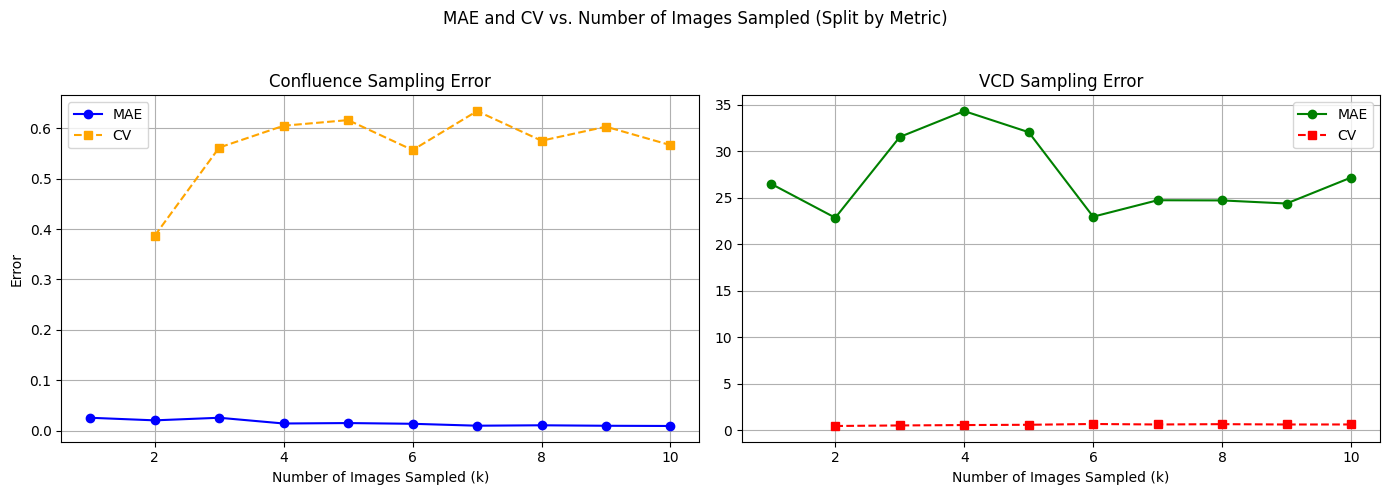

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Load data
root = Path("/content/drive/MyDrive/Images/sampling_analysis")
df_raw = pd.read_csv(root / "sampling_simulations_raw.csv")

# Group means
summary = df_raw.groupby(['k', 'metric']).agg(
    MAE=('MAE', 'mean'),
    CV=('CV', 'mean')
).reset_index()

# Separate metrics
conf = summary[summary['metric'] == 'CONF']
vcd = summary[summary['metric'] == 'VCD']

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharex=True)

# Plot Confluence metrics
axs[0].plot(conf['k'], conf['MAE'], marker='o', label='MAE', color='blue')
axs[0].plot(conf['k'], conf['CV'], marker='s', linestyle='--', label='CV', color='orange')
axs[0].set_title("Confluence Sampling Error")
axs[0].set_xlabel("Number of Images Sampled (k)")
axs[0].set_ylabel("Error")
axs[0].legend()
axs[0].grid(True)

# Plot VCD metrics
axs[1].plot(vcd['k'], vcd['MAE'], marker='o', label='MAE', color='green')
axs[1].plot(vcd['k'], vcd['CV'], marker='s', linestyle='--', label='CV', color='red')
axs[1].set_title("VCD Sampling Error")
axs[1].set_xlabel("Number of Images Sampled (k)")
axs[1].legend()
axs[1].grid(True)

plt.suptitle("MAE and CV vs. Number of Images Sampled (Split by Metric)")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("/content/drive/MyDrive/GWU/Praxis/Figures/sampling_error_split.png", dpi=300)
plt.show()


2025-07-08 21:28:42,512 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-07-08 21:28:42,517 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-07-08 21:28:42,683 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-07-08 21:28:42,687 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Figure saved ➜ /content/drive/MyDrive/GWU/Praxis/Figures/testset_variability.png


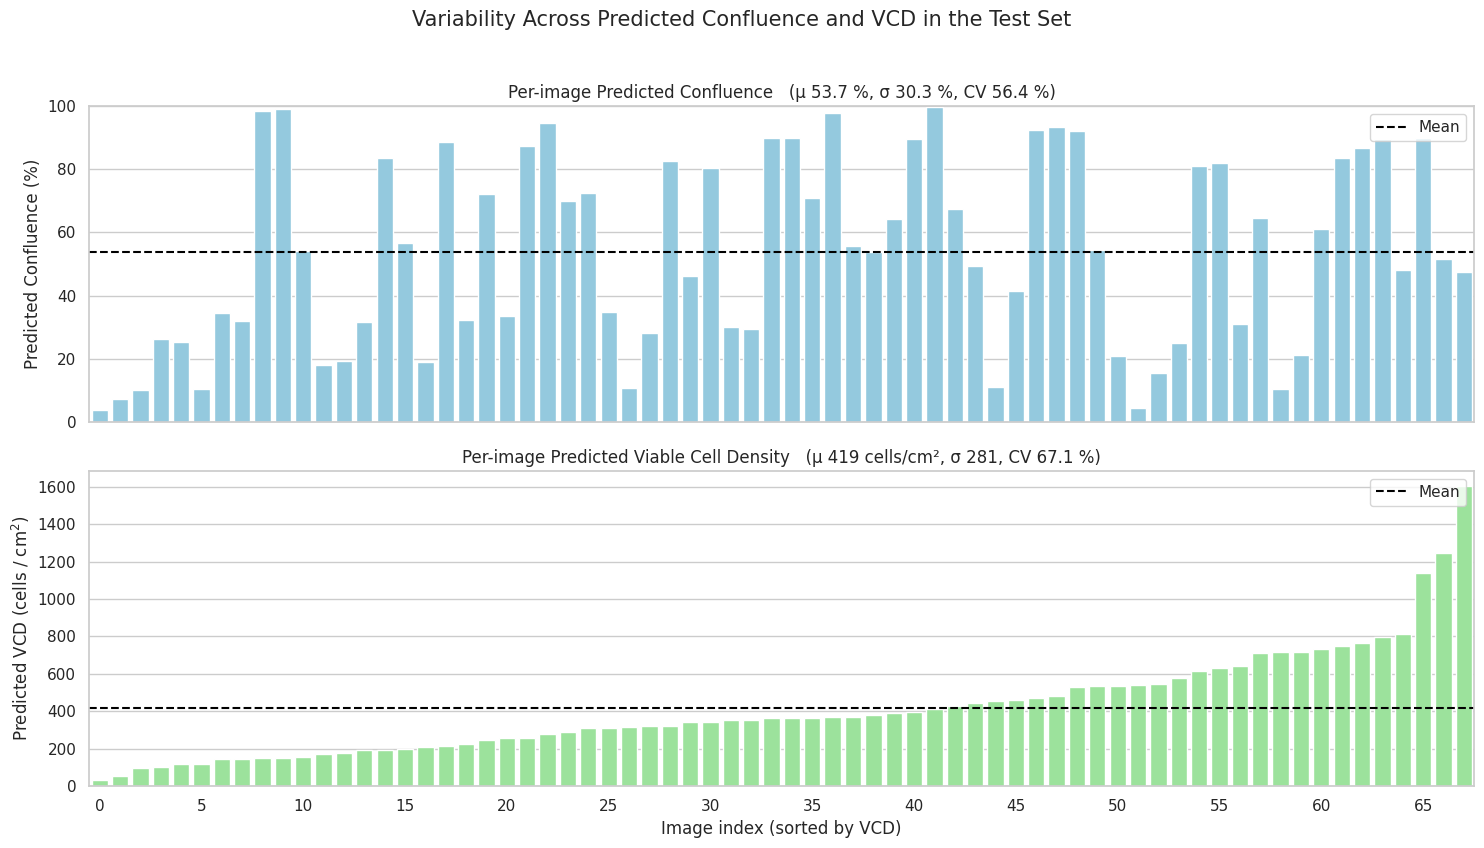

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import ticker
from pathlib import Path

# paths & data
root       = Path("/content/drive/MyDrive/Images/sampling_analysis")
fig_out    = Path("/content/drive/MyDrive/Figures/testset_variability.png")
df         = pd.read_csv(root / "all_image_kpis.csv")

# convert to numeric & sort by VCD so bars climb from low- to high-density
df["conf_pr"] = pd.to_numeric(df["conf_pr"], errors="coerce")
df["vcd_pr"]  = pd.to_numeric(df["vcd_pr"],  errors="coerce")
df_sorted     = df.sort_values("vcd_pr").reset_index(drop=True)

# basic descriptive stats
conf_pct = df_sorted["conf_pr"] * 100
vcd      = df_sorted["vcd_pr"]

stats = {
    "conf_mean" : conf_pct.mean(),
    "conf_sd"   : conf_pct.std(ddof=0),
    "conf_cv"   : conf_pct.std(ddof=0) / conf_pct.mean() * 100,
    "vcd_mean"  : vcd.mean(),
    "vcd_sd"    : vcd.std(ddof=0),
    "vcd_cv"    : vcd.std(ddof=0) / vcd.mean() * 100
}

# plottingsns.set(style="whitegrid")
fig, axs = plt.subplots(2, 1, figsize=(15, 9), sharex=True)

# Confluence (%) bar chart
sns.barplot(x=df_sorted.index, y=conf_pct, ax=axs[0], color="skyblue")
axs[0].axhline(stats["conf_mean"], ls=, c="black", label="Mean")
axs[0].set_ylabel("Predicted Confluence (%)")
axs[0].set_ylim(0, 100)
axs[0].set_title(
    f"Per-image Predicted Confluence   "
    f"(μ {stats['conf_mean']:.1f} %, σ {stats['conf_sd']:.1f} %, CV {stats['conf_cv']:.1f} %)",
    fontsize=12
)
axs[0].legend(loc="upper right")

# VCD bar chart
sns.barplot(x=df_sorted.index, y=vcd, ax=axs[1], color="lightgreen")
axs[1].axhline(stats["vcd_mean"], ls=, c="black", label="Mean")
axs[1].set_ylabel("Predicted VCD (cells / cm$^{2}$)")
axs[1].set_title(
    f"Per-image Predicted Viable Cell Density   "
    f"(μ {stats['vcd_mean']:.0f} cells/cm², σ {stats['vcd_sd']:.0f}, CV {stats['vcd_cv']:.1f} %)",
    fontsize=12
)
axs[1].legend(loc="upper right")

# shared x-axis: ticks every 5 images for readability
axs[1].set_xlabel("Image index (sorted by VCD)")
axs[1].set_xticks(np.arange(0, len(df_sorted), 5))
axs[1].xaxis.set_minor_locator(ticker.AutoMinorLocator())

fig.suptitle("Variability Across Predicted Confluence and VCD in the Test Set", fontsize=15, y=0.97)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

fig.savefig(fig_out, dpi=300)
print(f"Figure saved to {fig_out}")


In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
import random

# Load per-image ground truth and prediction data
root = Path("/content/drive/MyDrive/Images/sampling_analysis")
df_all = pd.read_csv(root / "all_image_kpis.csv")

# Define stratification bins and number of repeats
n_bins = 4
repeats = 50
sample_results_strat = []

# Stratify by VCD ground truth
df_all['vcd_bin'] = pd.qcut(df_all['vcd_gt'], q=n_bins, labels=False)

# Loop through each VCD bin
for bin_id, group in df_all.groupby('vcd_bin'):
    group = group.reset_index(drop=True)
    max_k = min(10, len(group))  # Ensure enough samples for each k

    for k in range(1, max_k + 1):
        for _ in range(repeats):
            sample = group.sample(n=k, replace=False)

            for metric in ['conf', 'vcd']:
                pr_vals = sample[f"{metric}_pr"]
                gt_vals = sample[f"{metric}_gt"]
                pred_avg = pr_vals.mean()
                gt_avg = gt_vals.mean()
                abs_err = abs(pred_avg - gt_avg)
                sq_err = (pred_avg - gt_avg) ** 2
                cv = pr_vals.std() / pr_vals.mean() if pr_vals.mean() != 0 else np.nan

                sample_results_strat.append({
                    "bin": int(bin_id),
                    "k": k,
                    "metric": metric.upper(),
                    "MAE": abs_err,
                    "RMSE": np.sqrt(sq_err),
                    "CV": cv,
                })

# Save stratified simulation results
df_stratified = pd.DataFrame(sample_results_strat)
df_stratified.to_csv(root / "sampling_stratified_simulations_by_vcd.csv", index=False)
print("Stratified (by VCD) sampling results saved to:")
print(root / "sampling_stratified_simulations_by_vcd.csv")


Stratified (by VCD) sampling results saved to:
/content/drive/MyDrive/GWU/Praxis/Images/sampling_analysis/sampling_stratified_simulations_by_vcd.csv


/tmp/ipython-input-37-2321760266.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipython-input-37-2321760266.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipython-input-37-2321760266.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipython-input-37-2321760266.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


Updated plots saved.


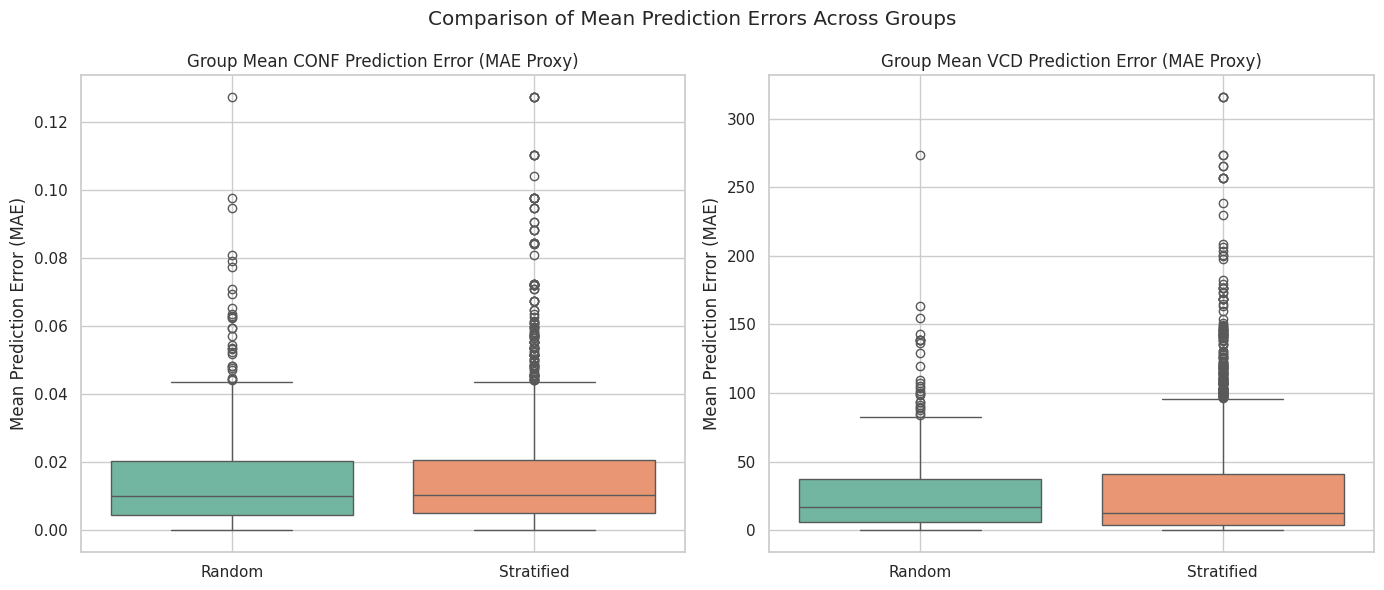

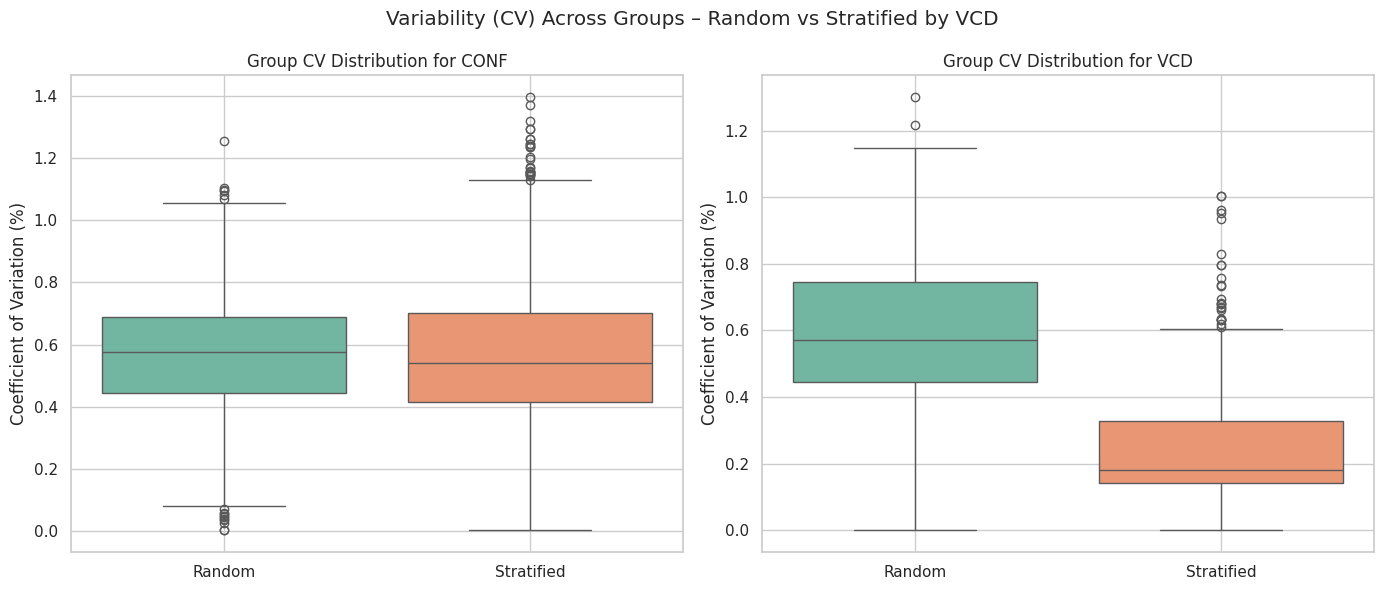

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Paths
analysis_dir = Path("/content/drive/MyDrive/Images/sampling_analysis")
figures_dir = Path("/content/drive/MyDrive/Figures")

# Load random and stratified (VCD-based) results
df_random = pd.read_csv(analysis_dir / "sampling_simulations_raw.csv")
df_strat = pd.read_csv(analysis_dir / "sampling_stratified_simulations_by_vcd.csv")

# Tag the sampling method
df_random["sampling"] = "Random"
df_strat["sampling"] = "Stratified"

# Assign group IDs (each k-sample draw is a group)
df_random["group_id"] = df_random.groupby(["metric", "k"]).cumcount()
df_strat["group_id"] = df_strat.groupby(["metric", "k"]).cumcount()

# Combine for analysis
df_combined = pd.concat([df_random, df_strat], ignore_index=True)

# Compute per-group mean prediction error (MAE proxy) and CV
group_stats = df_combined.groupby(["sampling", "metric", "k", "group_id"]).agg(
    mean_pred=("MAE", "mean"),
    cv=("CV", "mean")
).reset_index()

# MAE (Mean Prediction Error Proxy)
plt.figure(figsize=(14, 6))
for i, metric in enumerate(["CONF", "VCD"]):
    plt.subplot(1, 2, i + 1)
    sns.boxplot(
        data=group_stats[group_stats["metric"] == metric],
        x="sampling", y="mean_pred", palette="Set2"
    )
    plt.title(f"Group Mean {metric} Prediction Error (MAE Proxy)")
    plt.ylabel("Mean Prediction Error (MAE)")
    plt.xlabel("")
    plt.grid(True)

plt.suptitle("Comparison of Mean Prediction Errors Across Groups")
plt.tight_layout()
plt.savefig(figures_dir / "group_mean_error_boxplot_by_vcd.png")

# CV Distribution
plt.figure(figsize=(14, 6))
for i, metric in enumerate(["CONF", "VCD"]):
    plt.subplot(1, 2, i + 1)
    sns.boxplot(
        data=group_stats[group_stats["metric"] == metric],
        x="sampling", y="cv", palette="Set2"
    )
    plt.title(f"Group CV Distribution for {metric}")
    plt.ylabel("Coefficient of Variation (%)")
    plt.xlabel("")
    plt.grid(True)

plt.suptitle("Variability (CV) Across Groups – Random vs Stratified by VCD")
plt.tight_layout()
plt.savefig(figures_dir / "group_cv_boxplot_by_vcd.png")

print("Updated plots saved.")

In [ ]:
summary = group_stats.groupby(["sampling", "metric"]).agg(
    mean_group_error=("mean_pred", "mean"),
    std_group_error=("mean_pred", "std"),
    mean_cv=("cv", "mean"),
    std_cv=("cv", "std")
).round(3)

print(summary)
from scipy.stats import mannwhitneyu

from scipy.stats import mannwhitneyu

# Ensure column name matches
cv_col = "CV" if "CV" in group_stats.columns else "cv"

for metric in ["CONF", "VCD"]:
    grp = group_stats[group_stats["metric"] == metric]

    # Filter out missing CVs
    random_cv = grp[grp["sampling"] == "Random"][cv_col].dropna()
    strat_cv = grp[grp["sampling"] == "Stratified"][cv_col].dropna()

    if len(random_cv) > 0 and len(strat_cv) > 0:
        u_stat, p_val = mannwhitneyu(random_cv, strat_cv, alternative="greater")
        print(f"{metric} CV: U={u_stat}, p={p_val:.4f}")
    else:
        print(f"{metric} CV: Skipped due to missing or empty data")


                   mean_group_error  std_group_error  mean_cv  std_cv
sampling   metric                                                    
Random     CONF               0.015            0.016    0.567   0.212
           VCD               27.127           30.681    0.594   0.232
Stratified CONF               0.017            0.017    0.242   0.180
           VCD               30.576           30.425    0.590   0.216
CONF CV: U=709595.0, p=0.0000
VCD CV: U=403202.5, p=0.5580
